**The libraries imported**

In [3]:
from bs4 import BeautifulSoup
import requests
from IPython.core.display import display, HTML
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

**Assigned URL for box office mojo link to scrape movies**

In [62]:
"""Get HTML of webpage in Pyth"""

url = 'https://www.boxofficemojo.com/title/tt0118715/' 

response = requests.get(url)

In [63]:
response.status_code
page = response.text
soup = BeautifulSoup(page,"lxml")
title_string = soup.find('title').text
title = title_string.split('-')[0].strip()
dtg = soup.find(class_='mojo-performance-summary-table').find_all('span', class_='money')[0].text
dtg

'$18,034,458'

In [64]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

**Got different features of each movie and convert them into more numerical values**

In [65]:
runtime = get_movie_value(soup,'Run')
print(runtime)
rating = get_movie_value(soup,'MPAA')
print(rating)
release_date = get_movie_value(soup,'Release Date')
print(release_date)
release_date = release_date.split('\n')[0]  #Select the only the date
print(release_date)

1 hr 57 min
R
March 6, 1998
            (Domestic)
March 6, 1998


In [66]:
import dateutil.parser

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [67]:
raw_domestic_total_gross = dtg
domestic_total_gross = money_to_int(raw_domestic_total_gross)

raw_runtime = get_movie_value(soup,'Running')
runtime = runtime_to_minutes(raw_runtime)

raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
release_date = to_date(raw_release_date)

In [68]:
headers = ['movie title', 'domestic total gross',
           'runtime (mins)', 'rating', 'release date']

movie_data = []
movie_dict = dict(zip(headers, [title,
                                domestic_total_gross,
                                runtime,
                                rating, 
                                release_date]))

movie_data.append(movie_dict)
movie_data

[{'movie title': 'The Big Lebowski',
  'domestic total gross': 18034458,
  'runtime (mins)': 117,
  'rating': 'R',
  'release date': datetime.datetime(1998, 3, 6, 0, 0)}]

In [69]:
"""Lets now look at the entire table of G movies 1-200"""
def get_movie_grid(url):
    response = requests.get(url)
    page = response.text

    soup = BeautifulSoup(page,"lxml")
    table = soup.find('table')
    rows = [row for row in table.find_all('tr')]
    movies_dict = {}
    for row in rows[1:250]:
        items = row.find_all('td')
        link = items[0].find('a')
        title, url = link.text, link['href']
        movies_dict[title] = [url] + [i.text for i in items]
    movies = pd.DataFrame(movies_dict).T  #transpose
    movies.columns = ['link_stub', 'title', 'rank_g_movies','lifetime_gross', 'rank_overall', 'year']
    return movies


In [70]:
g1_movies = get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=G')
g2_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=G&offset=200')

In [73]:
g_movies = pd.concat([g1_movies,g2_movies])

In [75]:
g_movies

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year
Toy Story 4,/title/tt1979376/?ref_=bo_cso_table_1,Toy Story 4,1,"$434,038,008",24,2019
The Lion King,/title/tt0110357/?ref_=bo_cso_table_2,The Lion King,2,"$422,783,777",28,1994
Toy Story 3,/title/tt0435761/?ref_=bo_cso_table_3,Toy Story 3,3,"$415,004,880",30,2010
Finding Nemo,/title/tt0266543/?ref_=bo_cso_table_4,Finding Nemo,4,"$380,843,261",43,2003
"Monsters, Inc.",/title/tt0198781/?ref_=bo_cso_table_5,"Monsters, Inc.",5,"$289,916,256",101,2001
...,...,...,...,...,...,...
Wa-shoku Dream: Beyond Sushi,/title/tt3846402/?ref_=bo_cso_table_159,Wa-shoku Dream: Beyond Sushi,359,"$12,240","15,269",2015
Mr. Chibbs,/title/tt4633340/?ref_=bo_cso_table_160,Mr. Chibbs,360,"$8,302","15,797",2017
Boom Bust Boom,/title/tt3332308/?ref_=bo_cso_table_161,Boom Bust Boom,361,"$6,896","16,027",2016
School of Life,/title/tt6330246/?ref_=bo_cso_table_162,School of Life,362,"$6,300","16,118",2018


In [77]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
        - title 
        - domestic gross
        - runtime 
        - MPAA rating
        - full release date
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title', 'domestic_total_gross',
               'runtime_minutes', 'rating', 'release_date']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()

    #Get domestic gross
    raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    domestic_total_gross = money_to_int(raw_domestic_total_gross)

    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    runtime = runtime_to_minutes(raw_runtime)
    
    #Get rating
    rating = get_movie_value(soup,'MPAA')

    #Get release date
    raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
    release_date = to_date(raw_release_date)
    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers, [title,
                                domestic_total_gross,
                                runtime,
                                rating, 
                                release_date]))

    return movie_dict

**Used get_movie_dict to create a movie dictionary for each G rated page and convert it into a dataframe. From there, we clean the dataframe by replacing months with numerical values and ratings with MPPA labels. We then merge that data with the movie info page dataframe.**

g_movies_page_info_list = []

for link in g1_movies.link_stub:
    g_movies_page_info_list.append(get_movie_dict(link))

In [79]:
for link in g2_movies.link_stub:
    g_movies_page_info_list.append(get_movie_dict(link))

In [80]:
g_movies_page_info_list

[{'movie_title': 'Toy Story 4',
  'domestic_total_gross': 434038008,
  'runtime_minutes': 100,
  'rating': 'G',
  'release_date': datetime.datetime(2019, 6, 20, 0, 0)},
 {'movie_title': 'The Lion King',
  'domestic_total_gross': 422783777,
  'runtime_minutes': 88,
  'rating': 'G',
  'release_date': datetime.datetime(1994, 6, 15, 0, 0)},
 {'movie_title': 'Toy Story 3',
  'domestic_total_gross': 415004880,
  'runtime_minutes': 103,
  'rating': None,
  'release_date': datetime.datetime(2010, 6, 16, 0, 0)},
 {'movie_title': 'Finding Nemo',
  'domestic_total_gross': 380843261,
  'runtime_minutes': 100,
  'rating': None,
  'release_date': datetime.datetime(2003, 5, 30, 0, 0)},
 {'movie_title': 'Monsters, Inc.',
  'domestic_total_gross': 289916256,
  'runtime_minutes': 92,
  'rating': 'G',
  'release_date': datetime.datetime(2001, 11, 2, 0, 0)},
 {'movie_title': 'Monsters University',
  'domestic_total_gross': 268492764,
  'runtime_minutes': 104,
  'rating': 'G',
  'release_date': datetime.da

In [81]:
g_movies_page_info = pd.DataFrame(g_movies_page_info_list)  #convert list of dict to df
g_movies_page_info.set_index('movie_title', inplace=True)

g_movies_page_info

,domestic_total_gross,runtime_minutes,rating,release_date
movie_title,,,,
Toy Story 4,434038008,100.0,G,2019-06-20
The Lion King,422783777,88.0,G,1994-06-15
Toy Story 3,415004880,103.0,None,2010-06-16
Finding Nemo,380843261,100.0,None,2003-05-30
"Monsters, Inc.",289916256,92.0,G,2001-11-02
...,...,...,...,...
Wa,12240,107.0,None,2015-04-10
Mr. Chibbs,8302,86.0,None,2017-05-03
Boom Bust Boom,6896,74.0,None,2016-03-11


In [82]:
g_movies_page_info['rating']

movie_title
Toy Story 4          G
The Lion King        G
Toy Story 3       None
Finding Nemo      None
Monsters, Inc.       G
                  ... 
Wa                None
Mr. Chibbs        None
Boom Bust Boom    None
School of Life    None
In Safe Hands     None
Name: rating, Length: 363, dtype: object

In [83]:
g_movies_page_info.rating=g_movies_page_info.loc[(g_movies_page_info.rating == 'None'),'rating']='G'
g_movies_page_info

,domestic_total_gross,runtime_minutes,rating,release_date
movie_title,,,,
Toy Story 4,434038008,100.0,G,2019-06-20
The Lion King,422783777,88.0,G,1994-06-15
Toy Story 3,415004880,103.0,G,2010-06-16
Finding Nemo,380843261,100.0,G,2003-05-30
"Monsters, Inc.",289916256,92.0,G,2001-11-02
...,...,...,...,...
Wa,12240,107.0,G,2015-04-10
Mr. Chibbs,8302,86.0,G,2017-05-03
Boom Bust Boom,6896,74.0,G,2016-03-11


In [84]:
g_movies_final = g_movies.merge(g_movies_page_info, left_index=True, right_index=True)
g_movies_final

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date
101 Dalmatians,/title/tt0115433/?ref_=bo_cso_table_27,101 Dalmatians,27,"$136,189,294",445,1996,136189294,103.0,G,1996-11-27
102 Dalmatians,/title/tt0211181/?ref_=bo_cso_table_69,102 Dalmatians,69,"$66,957,026","1,240",2000,66957026,100.0,G,2000-11-22
16 Days of Glory,/title/tt0090559/?ref_=bo_cso_table_131,16 Days of Glory,331,"$83,857","12,070",1986,83857,284.0,G,1986-03-07
2001: A Space Odyssey,/title/tt0062622/?ref_=bo_cso_table_78,2001: A Space Odyssey,78,"$60,541,301","1,395",1968,60541301,149.0,G,1968-04-03
A Beautiful Planet,/title/tt2800050/?ref_=bo_cso_table_172,A Beautiful Planet,172,"$15,650,615","4,020",2016,15650615,NaN,G,2016-04-29
...,...,...,...,...,...,...,...,...,...,...
Winged Migration,/title/tt0301727/?ref_=bo_cso_table_193,Winged Migration,193,"$11,689,053","4,567",2002,11689053,98.0,G,2001-12-12
Wings of Courage,/title/tt0114952/?ref_=bo_cso_table_176,Wings of Courage,176,"$15,054,636","4,094",1995,15054636,NaN,G,1995-04-21
Winnie the Pooh,/title/tt1449283/?ref_=bo_cso_table_130,Winnie the Pooh,130,"$26,692,846","2,970",2011,26692846,63.0,G,2011-04-06
Wonders of the Sea,/title/tt5495792/?ref_=bo_cso_table_127,Wonders of the Sea,327,"$100,780","11,766",2019,100780,82.0,G,2018-05-17


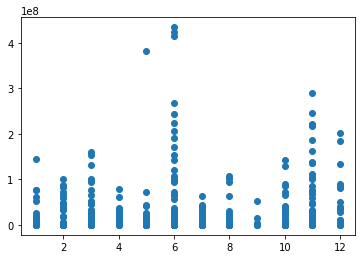

In [286]:
month = g_movies_final['release_date'].dt.month
g_movies_final['Month'] = month
plt.scatter(g_movies_final['Month'],g_movies_final['domestic_total_gross'])

**Load in the PG data and make follow the same process as the G rated movies. Note the left out rows had incomplete data and thus the boundaries for each for loop were a little ood.**

In [85]:
"""Lets now look at the entire table of PG movies 1-200"""
pg1_movies = get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG')
pg2_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?offset=200&by_mpaa=PG')
pg3_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=400')
pg4_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=600')
pg5_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG&offset=800')

In [86]:
pg_movies = pd.concat([pg1_movies,pg2_movies,pg3_movies,pg4_movies,pg5_movies])

In [ ]:
pg_movies

In [87]:
pg_movies_page_info_list = []

for link in pg1_movies.link_stub:
    pg_movies_page_info_list.append(get_movie_dict(link))
    


In [88]:
pg_movies_page_info_list

[{'movie_title': 'Incredibles 2',
  'domestic_total_gross': 608581744,
  'runtime_minutes': 118,
  'rating': 'PG',
  'release_date': datetime.datetime(2018, 6, 14, 0, 0)},
 {'movie_title': 'The Lion King',
  'domestic_total_gross': 543638043,
  'runtime_minutes': 118,
  'rating': 'PG',
  'release_date': datetime.datetime(2019, 7, 11, 0, 0)},
 {'movie_title': 'Beauty and the Beast',
  'domestic_total_gross': 504481165,
  'runtime_minutes': 129,
  'rating': 'PG',
  'release_date': datetime.datetime(2017, 3, 16, 0, 0)},
 {'movie_title': 'Finding Dory',
  'domestic_total_gross': 486295561,
  'runtime_minutes': 97,
  'rating': 'PG',
  'release_date': datetime.datetime(2016, 6, 15, 0, 0)},
 {'movie_title': 'Frozen II',
  'domestic_total_gross': 477373578,
  'runtime_minutes': 103,
  'rating': 'PG',
  'release_date': datetime.datetime(2019, 11, 20, 0, 0)},
 {'movie_title': 'Star Wars: Episode I',
  'domestic_total_gross': 474544677,
  'runtime_minutes': 136,
  'rating': 'PG',
  'release_date'

In [89]:
for link in pg2_movies.link_stub:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [90]:
pg3links=pg3_movies.link_stub[79]

In [91]:
for link in pg3_movies.link_stub[0:79]:
    pg_movies_page_info_list.append(get_movie_dict(link))


In [92]:
for link in pg3_movies.link_stub[80:200]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [93]:
for link in pg4_movies.link_stub[0:100]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [94]:
for link in pg4_movies.link_stub[100:150]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [95]:
for link in pg4_movies.link_stub[150:175]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [96]:
for link in pg4_movies.link_stub[175:176]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [97]:
for link in pg4_movies.link_stub[178:201]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [98]:
for link in pg5_movies.link_stub[1:201]:
    pg_movies_page_info_list.append(get_movie_dict(link))

In [99]:
pg_movies_page_info = pd.DataFrame(pg_movies_page_info_list)  #convert list of dict to df
pg_movies_page_info.set_index('movie_title', inplace=True)
pg_movies_page_info.rating=pg_movies_page_info.loc[(pg_movies_page_info.rating == 'None'),'rating']='PG'
pg_movies_page_info

,domestic_total_gross,runtime_minutes,rating,release_date
movie_title,,,,
Incredibles 2,608581744,118.0,PG,2018-06-14
The Lion King,543638043,118.0,PG,2019-07-11
Beauty and the Beast,504481165,129.0,PG,2017-03-16
Finding Dory,486295561,97.0,PG,2016-06-15
Frozen II,477373578,103.0,PG,2019-11-20
...,...,...,...,...
The Beautician and the Beast,11486880,105.0,PG,1997-02-07
Material Girls,11449638,98.0,PG,2006-08-18
The Powerpuff Girls Movie,11412414,73.0,PG,2002-07-03


In [100]:
pg_movies_final = pg_movies.merge(pg_movies_page_info, left_index=True, right_index=True)

In [101]:
pg_movies_final

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date
*batteries not included,/title/tt0092494/?ref_=bo_cso_table_1,*batteries not included,601,"$32,945,797","2,561",1987,32945797,106.0,PG,1987-12-18
1941,/title/tt0078723/?ref_=bo_cso_table_12,1941,612,"$31,755,742","2,650",1979,31755742,118.0,PG,1979-12-14
2010,/title/tt0086837/?ref_=bo_cso_table_126,2010,526,"$40,400,657","2,134",1984,40400657,116.0,PG,1984-12-07
2016: Obama's America,/title/tt2247692/?ref_=bo_cso_table_194,2016: Obama's America,594,"$33,449,086","2,530",2012,33449086,87.0,PG,2012-07-13
3 Ninjas,/title/tt0103596/?ref_=bo_cso_table_41,3 Ninjas,641,"$29,000,301","2,827",1992,29000301,84.0,PG,1992-08-07
...,...,...,...,...,...,...,...,...,...,...
Zelig,/title/tt0086637/?ref_=bo_cso_table_187,Zelig,987,"$11,798,616","4,559",1983,11798616,79.0,PG,1983-07-15
Zookeeper,/title/tt1222817/?ref_=bo_cso_table_60,Zookeeper,260,"$80,360,843",983,2011,80360843,102.0,PG,2011-07-06
Zoom,/title/tt0383060/?ref_=bo_cso_table_181,Zoom,981,"$11,989,328","4,535",2006,11989328,93.0,PG,2006-08-11
Zootopia,/title/tt2948356/?ref_=bo_cso_table_16,Zootopia,16,"$341,268,248",58,2016,341268248,108.0,PG,2016-02-10


In [280]:
month = pg_movies_final['release_date'].dt.month

In [282]:
pg_movies_final['Month'] = month

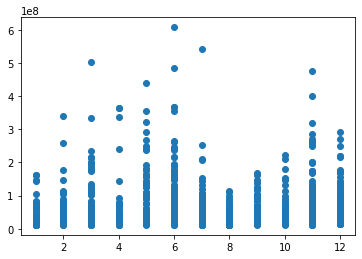

In [283]:
plt.scatter(pg_movies_final['Month'],pg_movies_final['domestic_total_gross'])

In [102]:
pg13_1_movies = get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG-13')
pg13_2_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?offset=200&by_mpaa=PG-13')
pg13_3_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG-13&offset=400')
pg13_4_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?offset=600&by_mpaa=PG-13')
pg13_5_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=PG-13&offset=800')

In [103]:
pg13_movies = pd.concat([pg13_1_movies,pg13_2_movies,pg13_3_movies,pg13_4_movies,pg13_5_movies])

In [104]:
pg13_movies

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year
Star Wars: Episode VII - The Force Awakens,/title/tt2488496/?ref_=bo_cso_table_1,Star Wars: Episode VII - The Force Awakens,1,"$936,662,225",1,2015
Avengers: Endgame,/title/tt4154796/?ref_=bo_cso_table_2,Avengers: Endgame,2,"$858,373,000",2,2019
Avatar,/title/tt0499549/?ref_=bo_cso_table_3,Avatar,3,"$760,507,625",3,2009
Black Panther,/title/tt1825683/?ref_=bo_cso_table_4,Black Panther,4,"$700,426,566",4,2018
Avengers: Infinity War,/title/tt4154756/?ref_=bo_cso_table_5,Avengers: Infinity War,5,"$678,815,482",5,2018
...,...,...,...,...,...,...
Balls of Fury,/title/tt0424823/?ref_=bo_cso_table_196,Balls of Fury,996,"$32,886,940","2,564",2007
In Her Shoes,/title/tt0388125/?ref_=bo_cso_table_197,In Her Shoes,997,"$32,880,591","2,565",2005
Bad News Bears,/title/tt0408524/?ref_=bo_cso_table_198,Bad News Bears,998,"$32,868,349","2,567",2005
Drillbit Taylor,/title/tt0817538/?ref_=bo_cso_table_199,Drillbit Taylor,999,"$32,862,104","2,568",2008


**Load in the PG-13 data and make follow the same process as the G and PG rated movies. Note the left out rows had incomplete data and thus the boundaries for each for loop were a little ood.**

In [105]:
pg13_movies_page_info_list = []

for link in pg13_1_movies.link_stub:
    pg13_movies_page_info_list.append(get_movie_dict(link))

In [106]:
for link in pg13_2_movies.link_stub:
    pg13_movies_page_info_list.append(get_movie_dict(link))

In [107]:
for link in pg13_3_movies.link_stub:
    pg13_movies_page_info_list.append(get_movie_dict(link))

In [108]:
for link in pg13_4_movies.link_stub:
    pg13_movies_page_info_list.append(get_movie_dict(link))

In [109]:
for link in pg13_5_movies.link_stub:
    pg13_movies_page_info_list.append(get_movie_dict(link))

In [110]:
pg13_movies_page_info_list

[{'movie_title': 'Star Wars: Episode VII',
  'domestic_total_gross': 936662225,
  'runtime_minutes': 138,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2015, 12, 16, 0, 0)},
 {'movie_title': 'Avengers: Endgame',
  'domestic_total_gross': 858373000,
  'runtime_minutes': 181,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2019, 4, 24, 0, 0)},
 {'movie_title': 'Avatar',
  'domestic_total_gross': 760507625,
  'runtime_minutes': 162,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2009, 12, 16, 0, 0)},
 {'movie_title': 'Black Panther',
  'domestic_total_gross': 700426566,
  'runtime_minutes': 134,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2018, 2, 13, 0, 0)},
 {'movie_title': 'Avengers: Infinity War',
  'domestic_total_gross': 678815482,
  'runtime_minutes': 149,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2018, 4, 25, 0, 0)},
 {'movie_title': 'Titanic',
  'domestic_total_gross': 659363944,
  'runtime_minutes': 194,
  'rating': 'PG-1

In [111]:
pg13_movies_page_info = pd.DataFrame(pg13_movies_page_info_list)  #convert list of dict to df
pg13_movies_page_info.set_index('movie_title', inplace=True)
pg13_movies_page_info.rating=pg13_movies_page_info.loc[(pg13_movies_page_info.rating == 'None'),'rating']='PG-13'
pg13_movies_page_info

,domestic_total_gross,runtime_minutes,rating,release_date
movie_title,,,,
Star Wars: Episode VII,936662225,138.0,PG-13,2015-12-16
Avengers: Endgame,858373000,181.0,PG-13,2019-04-24
Avatar,760507625,162.0,PG-13,2009-12-16
Black Panther,700426566,134.0,PG-13,2018-02-13
Avengers: Infinity War,678815482,149.0,PG-13,2018-04-25
...,...,...,...,...
Balls of Fury,32886940,90.0,PG-13,2007-08-29
In Her Shoes,32880591,130.0,PG-13,2005-09-28
Bad News Bears,32868349,113.0,PG-13,2005-07-22


In [112]:
pg13_movies_final = pg13_movies.merge(pg13_movies_page_info, left_index=True, right_index=True)
pg13_movies_final

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date
10 Cloverfield Lane,/title/tt1179933/?ref_=bo_cso_table_76,10 Cloverfield Lane,476,"$72,082,998","1,132",2016,72082998,103.0,PG-13,2016-03-10
10 Things I Hate About You,/title/tt0147800/?ref_=bo_cso_table_78,10 Things I Hate About You,878,"$38,178,166","2,248",1999,38178166,97.0,PG-13,1999-03-31
"10,000 BC",/title/tt0443649/?ref_=bo_cso_table_152,"10,000 BC",352,"$94,784,201",796,2008,94784201,109.0,PG-13,2008-03-05
13 Going on 30,/title/tt0337563/?ref_=bo_cso_table_9,13 Going on 30,609,"$57,231,747","1,497",2004,57231747,98.0,PG-13,2004-04-23
1408,/title/tt0450385/?ref_=bo_cso_table_77,1408,477,"$71,985,628","1,134",2007,71985628,104.0,PG-13,2007-06-22
...,...,...,...,...,...,...,...,...,...,...
"You, Me and Dupree",/title/tt0463034/?ref_=bo_cso_table_57,"You, Me and Dupree",457,"$75,628,110","1,064",2006,75628110,110.0,PG-13,2006-07-14
Young Guns II,/title/tt0100994/?ref_=bo_cso_table_178,Young Guns II,778,"$44,143,410","1,961",1990,44143410,104.0,PG-13,1990-08-03
Zoolander,/title/tt0196229/?ref_=bo_cso_table_163,Zoolander,763,"$45,172,250","1,919",2001,45172250,90.0,PG-13,2001-09-28
xXx,/title/tt0295701/?ref_=bo_cso_table_12,xXx,212,"$142,109,382",411,2002,142109382,124.0,PG-13,2002-08-09


In [271]:
month = pg13_movies_final['release_date'].dt.month

In [274]:
pg13_movies_final['Month'] = month

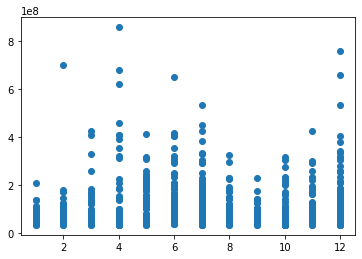

In [279]:
plt.scatter(pg13_movies_final['Month'],pg13_movies_final['domestic_total_gross'])

**Load in the R data and make follow the same process as the G, PG, and PG-13 rated movies.**

In [113]:
r1_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R')
r2_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R&offset=200')
r3_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R&offset=400')
r4_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R&offset=600')
r5_movies= get_movie_grid('https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R&offset=800')

In [114]:
r_movies = pd.concat([r1_movies,r2_movies,r3_movies,r4_movies,r5_movies])
r_movies

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year
The Passion of the Christ,/title/tt0335345/?ref_=bo_cso_table_1,The Passion of the Christ,1,"$370,782,930",47,2004
Deadpool,/title/tt1431045/?ref_=bo_cso_table_2,Deadpool,2,"$363,070,709",51,2016
American Sniper,/title/tt2179136/?ref_=bo_cso_table_3,American Sniper,3,"$350,126,372",56,2014
Joker,/title/tt7286456/?ref_=bo_cso_table_4,Joker,4,"$335,451,311",62,2019
It,/title/tt1396484/?ref_=bo_cso_table_5,It,5,"$328,828,874",69,2017
...,...,...,...,...,...,...
Three Days of the Condor,/title/tt0073802/?ref_=bo_cso_table_196,Three Days of the Condor,996,"$27,476,252","2,913",1975
Friday,/title/tt0113118/?ref_=bo_cso_table_197,Friday,997,"$27,467,564","2,914",1995
The Brothers,/title/tt0250274/?ref_=bo_cso_table_198,The Brothers,998,"$27,457,409","2,916",2001
Midsommar: The Directors Cut,/title/tt8772262/?ref_=bo_cso_table_199,Midsommar: The Directors Cut,999,"$27,426,361","2,918",2019


In [115]:
r_movies_page_info_list = []

for link in r1_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [116]:
for link in r2_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [117]:
for link in r3_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [118]:
for link in r4_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [119]:
for link in r5_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [120]:
r_movies_page_info = pd.DataFrame(r_movies_page_info_list)  #convert list of dict to df
r_movies_page_info.set_index('movie_title', inplace=True)
r_movies_page_info.rating=r_movies_page_info.loc[(r_movies_page_info.rating == 'None'),'rating']='R'
r_movies_page_info

,domestic_total_gross,runtime_minutes,rating,release_date
movie_title,,,,
The Passion of the Christ,370782930,127.0,R,2004-02-25
Deadpool,363070709,108.0,R,2016-02-09
American Sniper,350126372,133.0,R,2014-12-25
Joker,335451311,122.0,R,2019-10-02
It,328828874,135.0,R,2017-09-06
...,...,...,...,...
Three Days of the Condor,27476252,117.0,R,1975-09-24
Friday,27467564,91.0,R,1995-04-28
The Brothers,27457409,106.0,R,2001-03-23


In [121]:
r_movies_final = r_movies.merge(r_movies_page_info, left_index=True, right_index=True)

In [122]:
r_movies_final

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date
12 Monkeys,/title/tt0114746/?ref_=bo_cso_table_24,12 Monkeys,424,"$57,141,459","1,500",1995,57141459,129.0,R,1995-12-29
12 Strong,/title/tt1413492/?ref_=bo_cso_table_181,12 Strong,581,"$45,819,713","1,895",2018,45819713,130.0,R,2018-01-17
12 Years a Slave,/title/tt2024544/?ref_=bo_cso_table_28,12 Years a Slave,428,"$56,671,993","1,516",2013,56671993,134.0,R,2013-10-18
13 Hours,/title/tt4172430/?ref_=bo_cso_table_78,13 Hours,478,"$52,853,219","1,636",2016,52853219,144.0,R,2015-02-25
1917,/title/tt8579674/?ref_=bo_cso_table_40,1917,40,"$159,227,644",340,2019,159227644,119.0,R,2019-12-25
...,...,...,...,...,...,...,...,...,...,...
Zack and Miri Make a Porno,/title/tt1007028/?ref_=bo_cso_table_93,Zack and Miri Make a Porno,893,"$31,457,946","2,676",2008,31457946,101.0,R,2008-01-16
Zero Dark Thirty,/title/tt1790885/?ref_=bo_cso_table_182,Zero Dark Thirty,182,"$95,720,716",786,2012,95720716,157.0,R,2012-12-19
Zodiac,/title/tt0443706/?ref_=bo_cso_table_36,Zodiac,836,"$33,080,084","2,552",2007,33080084,157.0,R,2007-03-02
Zombieland,/title/tt1156398/?ref_=bo_cso_table_64,Zombieland,264,"$75,590,286","1,070",2009,75590286,88.0,R,2009-10-01


In [249]:
month = r_movies_final['release_date'].dt.month

In [246]:
r_movies_final['Month'] = month

In [262]:
r_movies_final.Month 

12 Monkeys                    12
12 Strong                      1
12 Years a Slave              10
13 Hours                       2
1917                          12
                              ..
Zack and Miri Make a Porno     1
Zero Dark Thirty              12
Zodiac                         3
Zombieland                    10
Zombieland: Double Tap        10
Name: Month, Length: 1006, dtype: int64

In [269]:
r_movies_final['year'],r_movies_final['domestic_total_gross']

(12 Monkeys                    1995
 12 Strong                     2018
 12 Years a Slave              2013
 13 Hours                      2016
 1917                          2019
                               ... 
 Zack and Miri Make a Porno    2008
 Zero Dark Thirty              2012
 Zodiac                        2007
 Zombieland                    2009
 Zombieland: Double Tap        2019
 Name: year, Length: 1006, dtype: object,
 12 Monkeys                     57141459
 12 Strong                      45819713
 12 Years a Slave               56671993
 13 Hours                       52853219
 1917                          159227644
                                 ...    
 Zack and Miri Make a Porno     31457946
 Zero Dark Thirty               95720716
 Zodiac                         33080084
 Zombieland                     75590286
 Zombieland: Double Tap         73123082
 Name: domestic_total_gross, Length: 1006, dtype: int64)

**Combine the dataframes for each rating into and entire dataframe for the entire dataset.  From here, we modify the dataset to sort for features to look at potential correlation.**

In [123]:
movies_final = pd.concat([g_movies_final,pg_movies_final,pg13_movies_final,r_movies_final])

In [124]:
movies_final

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date
101 Dalmatians,/title/tt0115433/?ref_=bo_cso_table_27,101 Dalmatians,27,"$136,189,294",445,1996,136189294,103.0,G,1996-11-27
102 Dalmatians,/title/tt0211181/?ref_=bo_cso_table_69,102 Dalmatians,69,"$66,957,026","1,240",2000,66957026,100.0,G,2000-11-22
16 Days of Glory,/title/tt0090559/?ref_=bo_cso_table_131,16 Days of Glory,331,"$83,857","12,070",1986,83857,284.0,G,1986-03-07
2001: A Space Odyssey,/title/tt0062622/?ref_=bo_cso_table_78,2001: A Space Odyssey,78,"$60,541,301","1,395",1968,60541301,149.0,G,1968-04-03
A Beautiful Planet,/title/tt2800050/?ref_=bo_cso_table_172,A Beautiful Planet,172,"$15,650,615","4,020",2016,15650615,NaN,G,2016-04-29
...,...,...,...,...,...,...,...,...,...,...
Zack and Miri Make a Porno,/title/tt1007028/?ref_=bo_cso_table_93,Zack and Miri Make a Porno,893,"$31,457,946","2,676",2008,31457946,101.0,R,2008-01-16
Zero Dark Thirty,/title/tt1790885/?ref_=bo_cso_table_182,Zero Dark Thirty,182,"$95,720,716",786,2012,95720716,157.0,R,2012-12-19
Zodiac,/title/tt0443706/?ref_=bo_cso_table_36,Zodiac,836,"$33,080,084","2,552",2007,33080084,157.0,R,2007-03-02
Zombieland,/title/tt1156398/?ref_=bo_cso_table_64,Zombieland,264,"$75,590,286","1,070",2009,75590286,88.0,R,2009-10-01


In [125]:
month = movies_final['release_date'].dt.month

In [126]:
movies_final['Month'] = month

In [132]:
movies_final.sort_values(by=['year'])

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date,Month
City Lights,/title/tt0021749/?ref_=bo_cso_table_154,City Lights,354,"$19,181","14,579",1931,19181,87.0,G,1931-01-30,1
Modern Times,/title/tt0027977/?ref_=bo_cso_table_117,Modern Times,317,"$163,577","10,891",1936,163577,87.0,G,1936-02-05,2
Snow White and the Seven Dwarfs,/title/tt0029583/?ref_=bo_cso_table_17,Snow White and the Seven Dwarfs,17,"$184,925,486",244,1937,184925486,83.0,G,1937-12-21,12
The Wizard of Oz,/title/tt0032138/?ref_=bo_cso_table_136,The Wizard of Oz,136,"$24,790,250","3,129",1939,24790250,102.0,G,1939-08-25,8
Gone with the Wind,/title/tt0031381/?ref_=bo_cso_table_14,Gone with the Wind,14,"$200,852,579",214,1939,200852579,238.0,G,1939-12-15,12
...,...,...,...,...,...,...,...,...,...,...,...
Harley Quinn: Birds of Prey,/title/tt7713068/?ref_=bo_cso_table_22,Harley Quinn: Birds of Prey,222,"$84,158,461",919,2020,84158461,109.0,R,2020-02-05,2
Onward,/title/tt7146812/?ref_=bo_cso_table_157,Onward,357,"$61,555,145","1,371",2020,61555145,102.0,PG,2020-02-29,2
Dolittle,/title/tt6673612/?ref_=bo_cso_table_74,Dolittle,274,"$77,047,065","1,038",2020,77047065,101.0,PG,2020-01-08,1
The Gentlemen,/title/tt8367814/?ref_=bo_cso_table_149,The Gentlemen,749,"$36,471,795","2,348",2020,36471795,113.0,R,2019-12-19,12


In [136]:
movies_by_year = movies_final.sort_values(by=['year'])

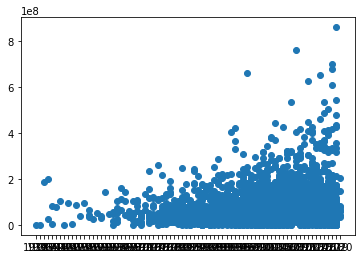

In [138]:
plt.scatter(movies_by_year['year'],movies_by_year['domestic_total_gross'])

In [148]:
movies_final.rating.value_counts()

R        1006
PG        980
PG-13     973
G         358
Name: rating, dtype: int64

In [149]:
from sklearn.preprocessing import LabelEncoder

In [151]:
le = LabelEncoder()

**This is converting the rating value to a numerical value and converts local ratings to global ratings.**

In [153]:
movies_final['ratingg'] = le.fit_transform(movies_final.rating)

In [193]:
movies_final

,link_stub,title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,runtime_minutes,rating,release_date,Month,ratingg
101 Dalmatians,/title/tt0115433/?ref_=bo_cso_table_27,101 Dalmatians,27,"$136,189,294",445,1996,136189294,103.0,G,1996-11-27,11,0
102 Dalmatians,/title/tt0211181/?ref_=bo_cso_table_69,102 Dalmatians,69,"$66,957,026",1240,2000,66957026,100.0,G,2000-11-22,11,0
16 Days of Glory,/title/tt0090559/?ref_=bo_cso_table_131,16 Days of Glory,331,"$83,857",12070,1986,83857,284.0,G,1986-03-07,3,0
2001: A Space Odyssey,/title/tt0062622/?ref_=bo_cso_table_78,2001: A Space Odyssey,78,"$60,541,301",1395,1968,60541301,149.0,G,1968-04-03,4,0
A Beautiful Planet,/title/tt2800050/?ref_=bo_cso_table_172,A Beautiful Planet,172,"$15,650,615",4020,2016,15650615,NaN,G,2016-04-29,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Zack and Miri Make a Porno,/title/tt1007028/?ref_=bo_cso_table_93,Zack and Miri Make a Porno,893,"$31,457,946",2676,2008,31457946,101.0,R,2008-01-16,1,3
Zero Dark Thirty,/title/tt1790885/?ref_=bo_cso_table_182,Zero Dark Thirty,182,"$95,720,716",786,2012,95720716,157.0,R,2012-12-19,12,3
Zodiac,/title/tt0443706/?ref_=bo_cso_table_36,Zodiac,836,"$33,080,084",2552,2007,33080084,157.0,R,2007-03-02,3,3
Zombieland,/title/tt1156398/?ref_=bo_cso_table_64,Zombieland,264,"$75,590,286",1070,2009,75590286,88.0,R,2009-10-01,10,3


In [174]:
movies_final.rank_overall.replace(',','', regex=True, inplace=True)

101 Dalmatians                  445
102 Dalmatians                 1240
16 Days of Glory              12070
2001: A Space Odyssey          1395
A Beautiful Planet             4020
                              ...  
Zack and Miri Make a Porno     2676
Zero Dark Thirty                786
Zodiac                         2552
Zombieland                     1070
Zombieland: Double Tap         1110
Name: rank_overall, Length: 3317, dtype: object

In [195]:
movies_final.rank_overall = pd.to_numeric(movies_final.year)

In [196]:
movies_final.year = pd.to_numeric(movies_final.rank_overall)

**Below is the heatmap showing correlations between features and pairplot**

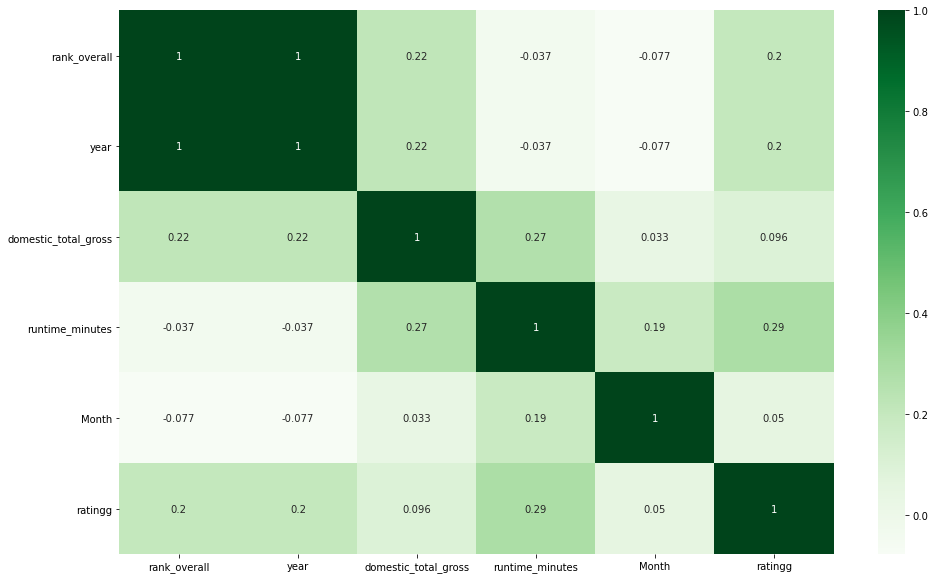

In [197]:
plt.figure(figsize=(16,10))
cor = movies_final.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

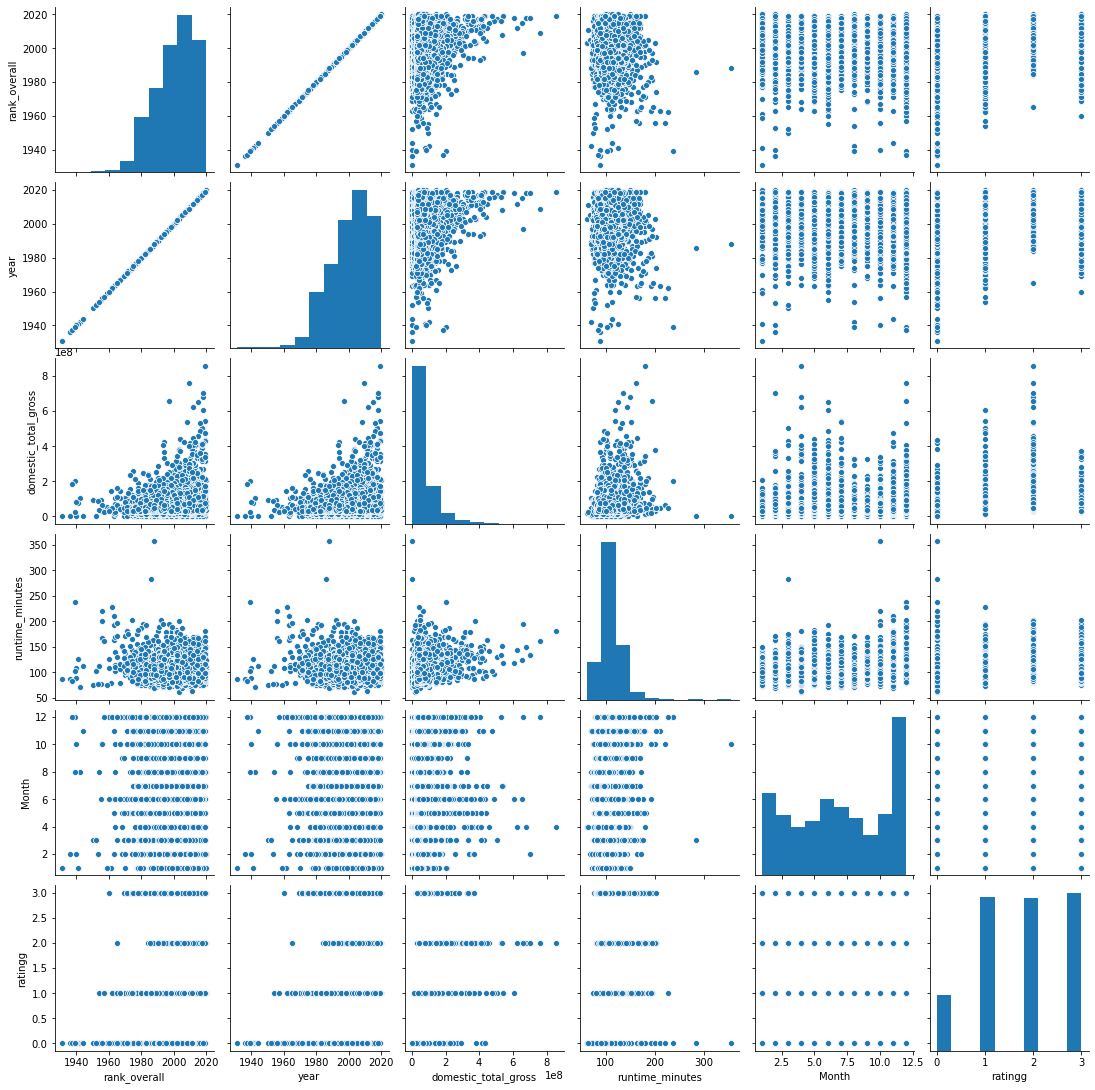

In [198]:
sns.pairplot(movies_final)

**Replaced the NA labels in minutes to median movie minutes**

In [202]:
movies_final.runtime_minutes.median()

106.0

In [204]:
movies_final.runtime_minutes = movies_final.runtime_minutes.fillna(movies_final.runtime_minutes.median())

**Running Regressions on data, plotted residuals for analysis, and performed cross validation**

In [4]:
lr_full = LinearRegression()
# Features
X = movies_final.loc(['year'])

# Target
y = movies_final['domestic_total_gross']

# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

NameError: name 'movies_final' is not defined

In [222]:
from sklearn.preprocessing import PolynomialFeatures

p = PolynomialFeatures()
X_poly = p.fit_transform(X)

lr_full = LinearRegression()
lr_full.fit(X_poly, y)
lr_full.score(X_poly, y)



0.1742393194286178

In [215]:
result = sm.OLS(X, y).fit()


In [218]:
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     domestic_total_gross   R-squared:                       0.123
Model:                              OLS   Adj. R-squared:                  0.121
Method:                   Least Squares   F-statistic:                     115.6
Date:                  Fri, 09 Oct 2020   Prob (F-statistic):           2.04e-92
Time:                          04:51:44   Log-Likelihood:                -64638.
No. Observations:                  3317   AIC:                         1.293e+05
Df Residuals:                      3312   BIC:                         1.293e+05
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.747e+09   1.94e+08    -14.157      0.000   -3.13e+09   -2.37e+09
rank_overall     6.777e+05   4.84e+04     14.004      0.000    5.83e+05    7.73e+05
Month           -1430.7574   3.64e+05     -0.004      0.997   -7.16e+05    7.13e+05
runtime_minutes  1.037e+06   6.37e+04     16.281      0.000    9.12e+05    1.16e+06
ratingg         -2.409e+06   1.31e+06     -1.833      0.067   -4.99e+06    1.68e+05
year             6.777e+05   4.84e+04     14.004      0.000    5.83e+05    7.73e+05
==============================================================================
Omnibus:                     2182.324   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35186.083
Skew:                           2.909   Prob(JB):                         0.00
Kurtosis:                      17.857   Cond. No.                     4.98e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

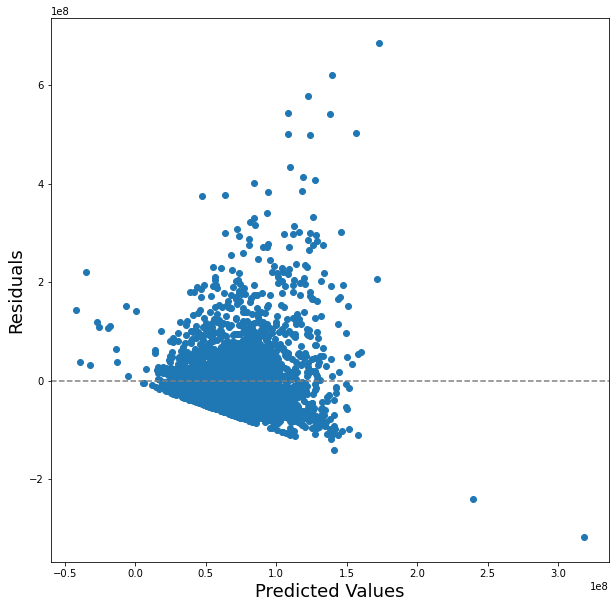

In [221]:
plt.figure(figsize=(10,10))
plt.scatter(fit.predict(), fit.resid)    #change this if working with sklearn

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18);

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [224]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [229]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)


lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)


lm_lasso = Lasso(alpha=1)
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [231]:
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_lasso.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_lasso.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.131
Ridge Regression val R^2: 0.131
Lasso Regression val R^2: 0.131
Degree 2 polynomial regression val R^2: 0.191
